# Model building

----------------------------------

This notebook details the model building (i.e. machine learning) steps for the project. First, we load in all relevant packages. We also set useful global options. Functions will be defined throughout the notebook as needed

In [1]:
#Load all packages
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import itertools
import warnings
import pickle
import joblib
import gzip

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Set some global options
pd.set_option('max_columns',100) #Its nice to see all columns

#Set some global plot defaults
sns.set(rc={"figure.figsize": (10, 8), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes',  labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes',  titlesize=18)                                  # fontsize of the title

-----------------------

We have our data in a pickle file which we load into a dataframe. We can also print out a few rows of the dataset to remind ourselves of our data.

In [3]:
with gzip.GzipFile('./data/cleaned_df.pkl.gz', 'r') as file:  
    df = joblib.load(file)

In [4]:
df.sample(5)

,Date,Category,Supervisor_District,Police_District,Latitude,Longitude,Source,Has_Media_Link,Tract,Poverty,Income,Unemployment,Population,Percent_Male,Percent_Pop_0_14,Percent_Pop_15_24,Percent_Pop_25_64,Percent_Pop_65_up,Percent_Pop_White,Percent_Pop_Black,Percent_Pop_Hispanic,Percent_Pop_Asian,Percent_Pop_Other,Is_Closed
327814,2017-01-18 06:15:34,Street and Sidewalk Cleaning,6.0,SOUTHERN,37.77579,-122.4125,Mobile/Open311,False,176.01,15.0,53136.0,4.0,7834.0,58.3,0.091907,0.088588,0.692877,0.126628,0.273041,0.099566,0.124457,0.435282,0.067654,True
540234,2017-12-24 03:17:00,Homeless Concerns,10.0,BAYVIEW,37.75773,-122.3927,Mobile/Open311,True,614.00,19.7,108869.0,8.7,6035.0,50.7,0.188070,0.076553,0.666777,0.068600,0.447722,0.093786,0.205468,0.162717,0.090307,True
157025,2016-02-23 09:56:14,Street and Sidewalk Cleaning,8.0,MISSION,37.76383,-122.4324,Phone,True,203.00,11.8,121875.0,3.4,3161.0,61.5,0.054730,0.085732,0.738690,0.120848,0.637457,0.018032,0.141095,0.139196,0.064220,True
81441,2015-08-31 10:44:23,Street and Sidewalk Cleaning,9.0,MISSION,37.75433,-122.4145,Mobile/Open311,False,228.03,8.7,70694.0,9.8,4637.0,50.9,0.139961,0.102006,0.695493,0.062540,0.377184,0.019625,0.479620,0.112788,0.010783,True
97657,2015-10-15 01:05:47,Street and Sidewalk Cleaning,9.0,INGLESIDE,37.73747,-122.4122,Mobile/Open311,False,254.02,2.7,146484.0,4.0,2965.0,52.3,0.127487,0.066779,0.656324,0.149410,0.450927,0.016863,0.207757,0.278246,0.046206,True


Recall the purpose of this project is to use additional census, or demographic, data to help predict the 311 request data. In that vein, we will define a new dataframe which only keeps that information and discards the rest.

In [5]:
#Re-scale some features
#Define new dataframe with only relevant columns
time_series = df.copy()
time_series.drop(['Supervisor_District', 'Police_District', 'Latitude', 'Longitude', 'Source', 'Has_Media_Link', 
                  'Is_Closed'], axis=1, inplace=True)

We also see that most of the census data columns are ratios and therefore defined only from 0 to 1. There are three columns, **Poverty**, **Unemployment**, and **Percent_Male** (male population percentage), which are also ratios but range from 0 to 100. So we will have to scale those back down to match the rest. 

In [6]:
#Scale to percent
time_series['Poverty'] = time_series['Poverty']/100.
time_series['Unemployment'] = time_series['Unemployment']/100.
time_series['Percent_Male'] = time_series['Percent_Male']/100.

In addition there are two columns, **Population** and **Income**, which are not ratios and whose range is arbitrary. In this case, we can use $scikit-learn$'s MaxAbsScaler function to scale these data columns from 0 to 1. These two processing steps are important since we want the features to be on equal footing with each other. 

In [7]:
#Scale to 0-1
time_series['Population'] = MaxAbsScaler().fit_transform(time_series['Population'].values.reshape(-1,1)).\
                                           reshape(1,-1)[0]
time_series['Income'] = MaxAbsScaler().fit_transform(time_series['Income'].values.reshape(-1,1)).\
                                       reshape(1,-1)[0]

Now that we have a dataframe ready to be modeled, let's map out our strategy. We want to model how 311 requests are made to San Francisco. That data is granular, as it is recorded to the second. It would be difficult to predict a time series with that kind of granularity. Instead, we will first upsample to a week and get the weekly count. Then we can for each census **Tract** and request **Category**, model the weekly count data given the particular census data. Note also, we are surmising the additional census data will help the model. We will have to check this portion of our assumption with the data. 

We will use a SARIMA(X) model to fit our data. Because the weekly count data is a simple time series, we can apply the well-known ARIMA algorithm (implemented in $statsmodels$) to our data. The normal method to apply this type of model is to follow these steps:

- Visualize the time series data
- Stationarize the data
- Find optimal AR and MA terms from the (Partial) Autocorrelation plots
- Fit the model

This procedure is problematic for us because of the number of time series data we will be creating. There are 8 **Categories** and 195 **Tracts** which implies 1,560 time series to look at. Clearly determining the best way to optimize each time series cannot be done by hand. Instead we will loop over various parameters to find the optimal one. This is basically the same as hyperparameter tuning a machine learning model, such as (regularized) linear regression. Similarly here, we will train using only a subset of the full data and test against the remaining data. Mean absolute error is the metric to score the different models.  

There are some additional remarks to make. First, we will use a Seasonal ARIMA model to incorporate likely seasonal patterns in the data. Second, the census data columns are treated as exogenous variables and are input as such into the model. We will also optimize a SARIMA model without the census data to give us an understanding of how much the extra information actually helps. Third, to help us with the tuning, we will define some helper functions and make our code (slightly) easier to read. These are defined below. 

In [8]:
#Specify to ignore possible warning messages from statsmodels for the ARIMA models
warnings.filterwarnings("ignore")

In [9]:
#Function that performs the hyperparamter tuning
def param_search(params, params_sea, endog_data, exog_data=None):
    
    #Optimized metric/params 
    best_param = best_param_seasonal = ()
    best_aic = best_mse = best_mae = np.inf
    
    #Print out info
    model_str = ' '
    if exog_data is not None: model_str = ', with exog vars, '
    print '\tFinding the best fit%sfrom %i parameter combos... ' % (model_str, len(params_sea)*len(params)),
    
    #Loop over all params
    start = time.time()
    for pdq in params:
        for pdq_sea in seasonal_pdq:
            #Try the model in case it somehow fails
            try:    
                mod = sm.tsa.statespace.SARIMAX(endog=endog_data,
                                                exog=exog_data,
                                                order=pdq,
                                                seasonal_order=pdq_sea,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit(disp=False)

                mae = mean_absolute_error(results.fittedvalues, endog_data)
                mse = mean_squared_error (results.fittedvalues, endog_data)

                #Optimize on the Mean absolute error, other options can be tried
                if best_mae > mae:
                    best_mae = mae
                    best_param = pdq
                    best_param_seasonal = pdq_sea
                    
            #Ignore this set of params if model fails        
            except:
                continue
                
    #Print out the time it took        
    end = time.time()
    delta = end - start
    print(' and it took %02d:%02d:%02d.' % (delta//3600., delta//60., delta%60.))      
    print('\t  * Best fitted model is ARIMA{}x{} with score: {:.3f}'.format(best_param, best_param_seasonal, best_mae))
 
    #Return the best model
    return([best_param, best_param_seasonal, best_mae])

#Function to get the score/forecast of the model
def score_model(model, endog_data, exog_data=None,  
                start_date=pd.to_datetime('2017-10-08'), end_date=pd.to_datetime('2017-12-31')):
    
    #In case the prediction fails (it should not)
    try:
        pred = model.get_prediction(start=start_date, end=end_date, exog=exog_data, dynamic=True)
        ci = pred.conf_int()
        
    #Return something obvious    
    except:
        return (-1,0,0)
    
    #Define metrics that can be used
    aic = model.aic
    mae = mean_absolute_error(pred.predicted_mean, endog_data) 
    mse = mean_squared_error(pred.predicted_mean, endog_data) 
        
    #Return the metric and predicted values + errors (95% CI)    
    return(mae, pred.predicted_mean, ci)

We can now specify the range of the SARIMA model parameters we will tune over. 

In [10]:
#Define the SARIMA parameters
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(1,0,0,52), (0,1,0,52), (0,0,1,52), (1,1,0,52), (0,1,1,52)]

It is worth revisiting an important data wrangling choice made earlier in the project. Because of computational concerns a majority of the data was dropped. This affects us here in two separate ways. First, many of the 1,560 time series even when upsampled from a second to a week, still have null entries. We could potentially overcome this by interpolating; however, this adds an extra complication and source of bias in the analysis. Considering part of this data issue is the aforementioned data dropping, a re-do of this project would simply keep that data and not run into this problem (as often). Second, there is yet another limiting computational cost. Here running the hypertuning code is quite lengthy so for notebook presentation purposes a minimum number of counts is imposed. This number is fairly arbitrary and simply reflects the computational resources needed. Instead, this computation is performed separately and saved to local disk. This way we can access the results anytime.

So let's setup our code going through all combinations of parameters and saving the results. We will also plot the fitted results against the observed time series. In addition we will plot the model prediction against the observed. 

Street and Sidewalk Cleaning
->  Tract : 177.0
	Finding the best fit, with exog vars, from 135 parameter combos...   and it took 00:20:49.
	  * Best fitted model is ARIMA(2, 0, 1)x(1, 0, 0, 52) with score: 8.739
	Finding the best fit from 135 parameter combos...   and it took 00:06:21.
	  * Best fitted model is ARIMA(1, 0, 2)x(1, 0, 0, 52) with score: 9.159

	Plotting the observed, fit and forecast time series: 


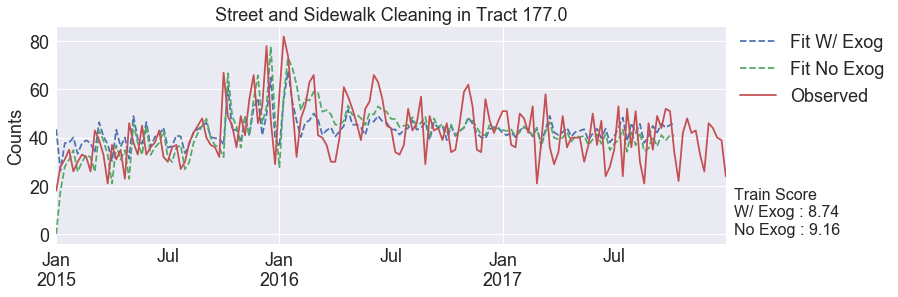

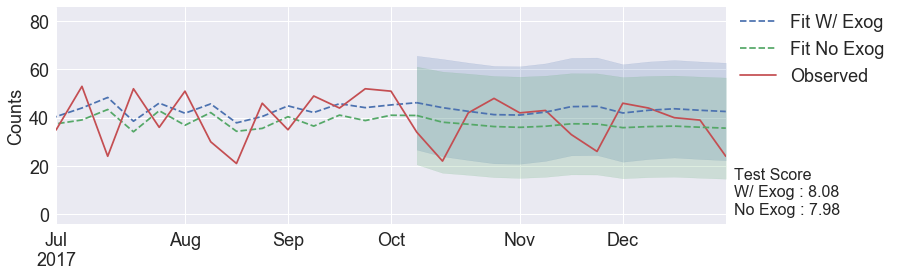

->  Tract : 178.02
	Finding the best fit, with exog vars, from 135 parameter combos...   and it took 00:21:56.
	  * Best fitted model is ARIMA(2, 1, 0)x(1, 0, 0, 52) with score: 8.949
	Finding the best fit from 135 parameter combos...   and it took 00:05:38.
	  * Best fitted model is ARIMA(2, 1, 0)x(1, 0, 0, 52) with score: 8.949

	Plotting the observed, fit and forecast time series: 


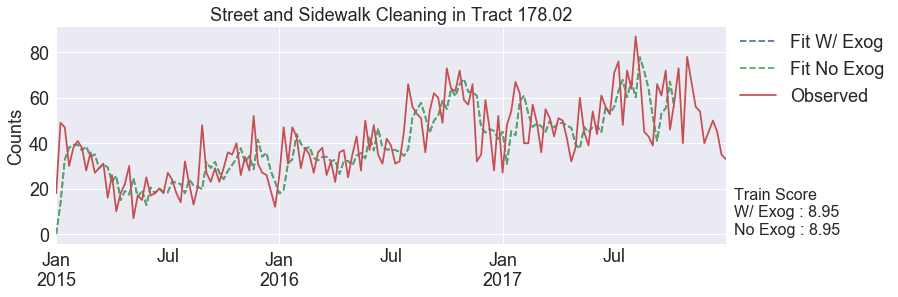

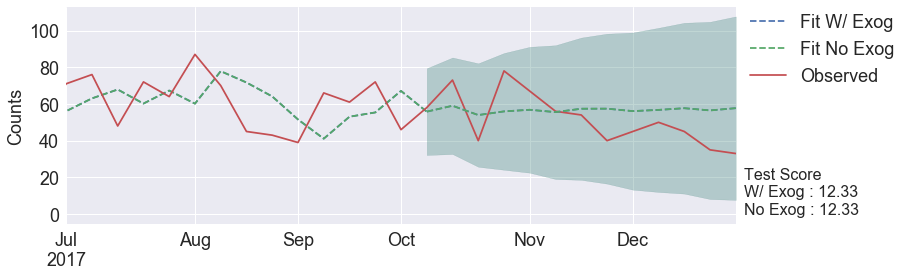

->  Tract : 201.0
	Finding the best fit, with exog vars, from 135 parameter combos...   and it took 00:27:26.
	  * Best fitted model is ARIMA(2, 0, 0)x(1, 0, 0, 52) with score: 9.953
	Finding the best fit from 135 parameter combos...   and it took 00:09:41.
	  * Best fitted model is ARIMA(2, 0, 2)x(1, 0, 0, 52) with score: 10.386

	Plotting the observed, fit and forecast time series: 


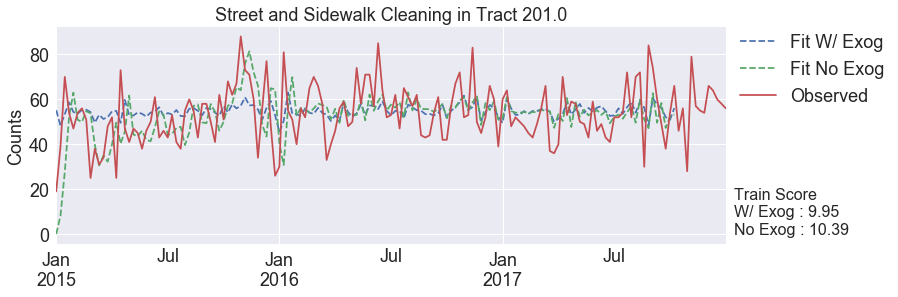

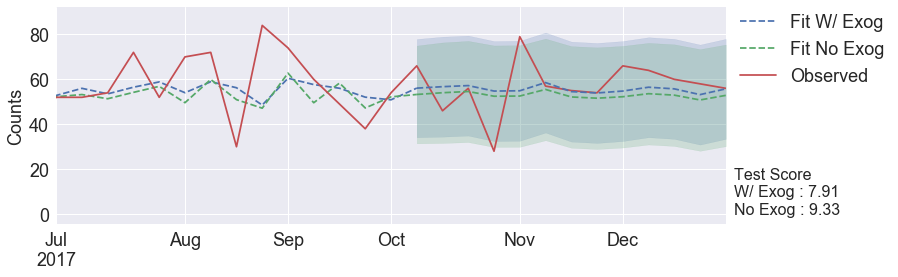

Graffiti
->  Tract : 208.0
	Finding the best fit, with exog vars, from 135 parameter combos...   and it took 00:24:10.
	  * Best fitted model is ARIMA(1, 0, 1)x(1, 0, 0, 52) with score: 25.755
	Finding the best fit from 135 parameter combos...   and it took 00:06:38.
	  * Best fitted model is ARIMA(2, 0, 0)x(1, 0, 0, 52) with score: 26.539

	Plotting the observed, fit and forecast time series: 


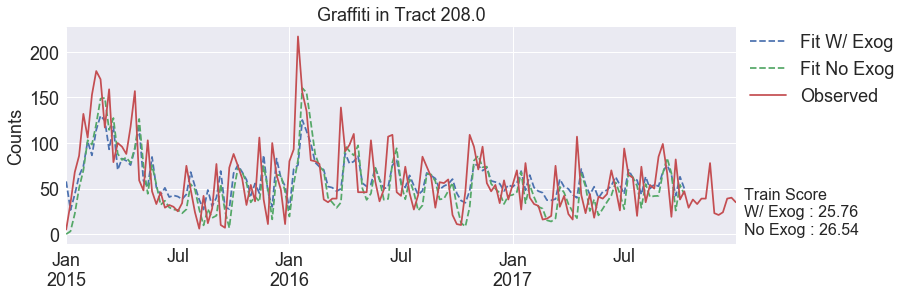

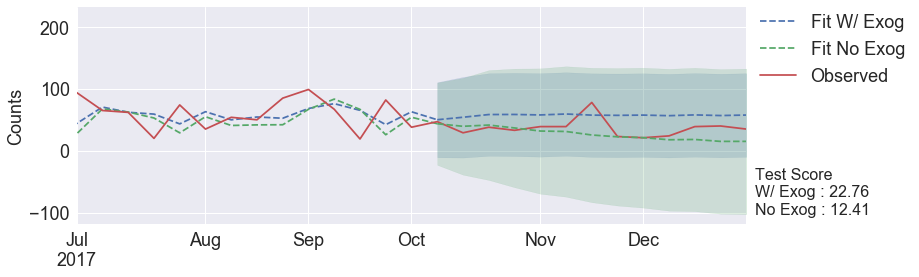

Abandoned Vehicle
Homeless Concerns
Encampments
Sewer Issues
Streetlights
Damaged Property


In [11]:
#Save the results
model_results = pd.DataFrame(columns=['Category', 'Tract', 'Score_exog', 'Score_no_exog'])

#Loop over each category and tract
model_i = 0
for feature in df.Category.value_counts().index:

    #Get each category
    ind_category = time_series[time_series.Category == feature].copy()
    ind_category.drop('Category', axis=1, inplace=True)
    print('%s\n%s' % (feature, '='*30))
    
    #Loop over tract
    for tract, group in ind_category.groupby('Tract'):
        
        #Get each tract
        temp = group.set_index('Date')['Tract'].resample('W').count().to_frame(name='Counts')

        #Keep only resampled time series with no missing weeks
        if len(temp)==157:
            for col in group.drop(['Date'], axis=1).columns:
                temp[col] = [group[col].mean()]*len(temp)
        else:
            continue
            
        #Select only those with certain (i.e. lots) total request counts    
        if len(group) < 6100: 
            continue
            
        
        print('->  Tract : %s' % tract)
                
        #Train test split    
        x_data = temp.drop(['Counts', 'Tract'], axis=1)
        y_data = temp.drop('Tract', axis=1)['Counts']
        x_train = x_data[:-12]
        y_train = y_data[:-12]
        x_test  = x_data[-12:]
        y_test  = y_data[-13:]
                
        #Tune for best parameters with census variables
        best_param, best_param_seasonal, best_score_exog = param_search(pdq, seasonal_pdq, y_train, x_train)
        
        #Forecast with exog (exog=census variables)
        mod_exog = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, 
                                             order=best_param, seasonal_order=best_param_seasonal, 
                                             enforce_invertibility=False, enforce_stationarity=False)
        res_exog = mod_exog.fit(disp=False)
        score_exog, pred_exog, ci_exog = score_model(res_exog, y_test, x_test)
        
        #Tune for best parameters without census variables
        best_param, best_param_seasonal, best_score_no_exog = param_search(pdq, seasonal_pdq, y_train)
        mod_no_exog = sm.tsa.statespace.SARIMAX(endog=y_train, order=best_param, seasonal_order=best_param_seasonal, 
                                                enforce_invertibility=False, enforce_stationarity=False)
        res_no_exog = mod_no_exog.fit(disp=False)
        score_no_exog, pred_no_exog, ci_no_exog = score_model(res_no_exog, y_test)
            
            
        #Save the results
        model_results.loc['%i' % model_i] = [feature, tract, score_exog, score_no_exog]
        model_i = model_i + 1   
        
        
        print('\n\tPlotting the observed, fit and forecast time series: ')
            
            
        #Plot the observed and two fit models    
        plt.figure(figsize=(12,4))    
        res_exog.fittedvalues.plot(label='Fit W/ Exog', linestyle='--')
        res_no_exog.fittedvalues.plot(label='Fit No Exog', linestyle='--')
        temp.Counts.plot(label='Observed')
        plt.title('%s in Tract %s' % (feature, tract))
        plt.ylabel('Counts')
        ax1 = plt.axes()
        ax1.xaxis.label.set_visible(False)
        plt.text(0.91, 0.16, 'Train Score\n%-7s : %.2f\n%-7s : %.2f' % 
                 ('W/ Exog', best_score_exog, 'No Exog', best_score_no_exog), fontsize=16, 
                 transform=plt.gcf().transFigure)
        plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        plt.show()         
        
        #Plot the observed, fit and forecasted models, in limited date range
        plt.figure(figsize=(12,4))    
        ax = res_exog.fittedvalues.plot(label='Fit W/ Exog', linestyle='--')
        res_no_exog.fittedvalues.plot(label='Fit No Exog', linestyle='--')
        temp.Counts.plot(ax=ax, label='Observed')
        pred_exog.plot(ax=ax, label='_nolegend_', color=sns.color_palette()[0], linestyle='--')
        pred_no_exog.plot(ax=ax, label='_nolegend_', color=sns.color_palette()[1], linestyle='--')
        #Draw shaded region for 95% CI for prediction
        ax.fill_between(ci_exog.index, ci_exog.iloc[:, 0], ci_exog.iloc[:, 1], 
                        color=sns.color_palette()[0], alpha=0.2)
        ax.fill_between(ci_no_exog.index, ci_no_exog.iloc[:, 0], ci_no_exog.iloc[:, 1], 
                        color=sns.color_palette()[1], alpha=0.2)  
        ax.set_ylabel('Counts')
        plt.text(0.91, 0.16, 'Test Score\n%-7s : %.2f\n%-7s : %.2f' % 
                 ('W/ Exog', score_exog, 'No Exog', score_no_exog), 
                 fontsize=16, transform=plt.gcf().transFigure)
        plt.xlim(('2017-07-01','2017-12-31'))
        ax1 = plt.axes()
        ax1.xaxis.label.set_visible(False)
        plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        plt.show()   
        

While we have determined the SARIMA parameters algorithmically, it is good to perform some spot checks. In this case we can somewhat arbitrarily pick a time series. In other words we can arbitrarily select the second (request count data) time series from the earlier loop, looking at the Street and Sidewalk Cleaning in **Tract** 178.02. 

In [12]:
#Chose the first time series data from the earlier for loop
inspect = time_series.loc[(time_series.Category=='Street and Sidewalk Cleaning') & (time_series.Tract==178.02)]
inspect = inspect.set_index('Date')['Tract'].resample('W').count().to_frame(name='Counts')

We can then re-fit the time series with the optimized parameters and look at the results directly. 

In [13]:
#ARIMA(2, 1, 0)x(1, 0, 0, 52)
mod = sm.tsa.statespace.SARIMAX(inspect, order=(2,1,0), seasonal_order=(1,0,0,52))
results = mod.fit(disp=False)
print results.summary()

                                 Statespace Model Results                                 
Dep. Variable:                             Counts   No. Observations:                  157
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 52)   Log Likelihood                -602.280
Date:                            Thu, 19 Apr 2018   AIC                           1212.560
Time:                                    19:54:36   BIC                           1224.785
Sample:                                01-04-2015   HQIC                          1217.525
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5818      0.083     -7.045      0.000      -0.744      -0.420
ar.L2         -0.3655      0.073   

The $p$-values are not particularly significant for the SARIMA parameters. But we can take a look at the actual fit quality by plotting its diagnostics. 

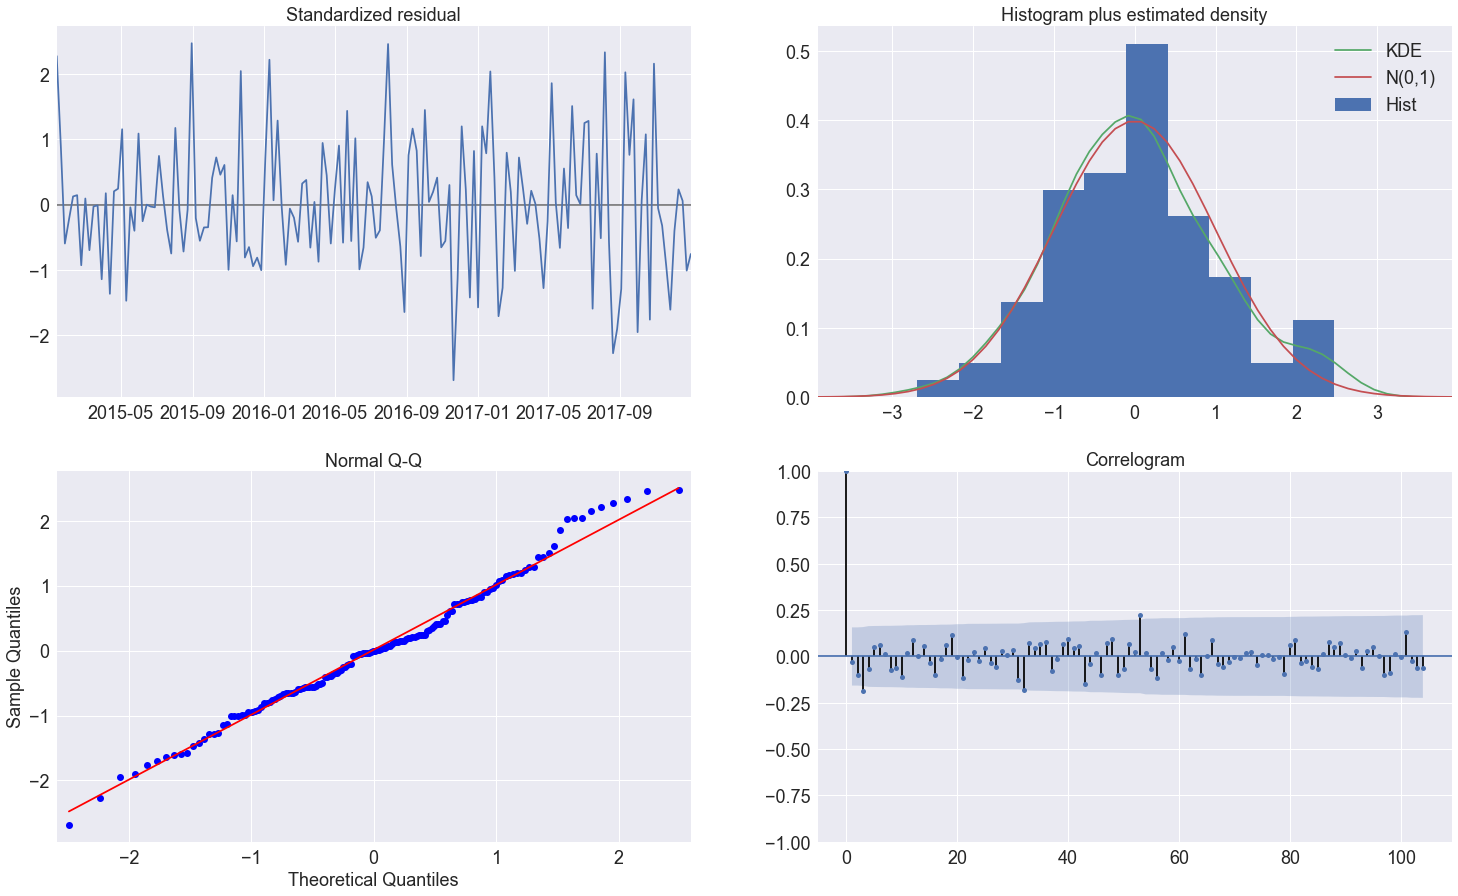

In [14]:
results.plot_diagnostics(figsize=(25,15), lags=52*2)
plt.show()

We can see that the residuals (top left panel) do not seem to have any particular order. This is good as patterns in the residual plot would imply room for improvement. Similarly the correlogram (bottom right panel) shows no particular correlation between lagged versions of the residuals. The residuals also are decently normally distributed (top right and bottom left panels). It is not perfect but again does not show any alarming inconsistencies. So we can be relatively happy that this model is well fit. 

We can now have a look at how the models with the census variables fared against the the ones without. The defined function below takes care of this. We determine which model is better or if they are the roughly the same (within about 0.1%).  

In [15]:
#Compare two columns with 3 categories
def comp_res(s1, s2, diff=0.001):
    return np.where(np.abs((s1-s2)/s1)<diff, 'Tie', np.where(s1<s2, 'Better', 'Worse'))

We can use this on the time series we have fit and see which ones are better. 

In [16]:
model_results['Results'] = comp_res(model_results.Score_exog, model_results.Score_no_exog)
model_results

#Save the model results to file
##model_results.to_csv('./data/tract_category_model_res.csv')

,Category,Tract,Score_exog,Score_no_exog,Results
0,Street and Sidewalk Cleaning,177.00,8.075682,7.983722,Worse
1,Street and Sidewalk Cleaning,178.02,12.334578,12.334578,Tie
2,Street and Sidewalk Cleaning,201.00,7.909278,9.331706,Better
3,Graffiti,208.00,22.757547,12.407253,Worse


We see there is a split on the census variables improving the model. However, this is only with four time series. Instead we can look at a much bigger sample size. We can go through more time series and save the full results to a local file. This has already been done, so we can load in that file to check the outcomes. 

In [17]:
total_results = pd.read_csv('./data/tract_category_model_res.csv', 
                            names=['Category', 'Tract', 'Score_exog', 'Score_no_exog'])

total_results['Results'] = comp_res(total_results.Score_exog, total_results.Score_no_exog)

In [18]:
total_results.Results.value_counts()*100./len(total_results)

Better    39.354839
Worse     34.838710
Tie       25.806452
Name: Results, dtype: float64

We can see that the models with census variables tend to lead to better fits more often than not, excluding ties. We can also check the distribution amongst the eight **Categories**. 

In [19]:
pd.crosstab(total_results.Category, total_results.Results, normalize='index')

Results,Better,Tie,Worse
Category,,,
Abandoned Vehicle,0.363636,0.227273,0.409091
Damaged Property,0.500000,0.125000,0.375000
Encampments,0.222222,0.666667,0.111111
Graffiti,0.333333,0.240741,0.425926
Homeless Concerns,0.521739,0.260870,0.217391
Sewer Issues,0.517241,0.034483,0.448276
Street and Sidewalk Cleaning,0.383459,0.323308,0.293233
Streetlights,0.400000,0.000000,0.600000


There is a similar distribution of for each **Category** as there is overall. This is somewhat reassuring that this rate is not dependent on **Category** type. 

That wraps up the time series fitting where we showed we can model the request counts, per week, for individual **Categories** in particular census **Tracts**. We also showed that we could include additional variables, census variables, to the time series modeling and achieve better results. 

--------------------------

Et fin.